In [2]:
!pip uninstall -y tensorflow

Uninstalling tensorflow-2.5.0:
  Successfully uninstalled tensorflow-2.5.0


In [3]:
!pip install tensorflow-gpu==2.0.0-beta0
!pip install tensorflow_hub
!pip install tensorflow
!pip install --upgrade tensorflow
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

     |████████████████████████████████| 454.3MB 41kB/s 
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.5.0)


ImportError: ignored

In [ ]:
pd.set_option("display.precision", 8)

Connecten naar Google drive. Zodat je files niet op eigen computer hoeft op te slaan.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_root='/content/drive/My Drive/Dataset/Images'

In [ ]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

/content/drive/My Drive/Dataset/Images


NameError: ignored

Meer batch info, zie direct welke classen er binnen je dataset zijn.

In [ ]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 3)
['Adidas Sb' 'Prada' 'Rolex']


Prep voor training

In [ ]:
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


Start met trainen!


1.   Pas epochs aan. (Aantal keer door de dataset)





In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator,
epochs=50,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history

Epoch 1/50
5/5 [==============================] - 54s 10s/step - loss: 1.3322 - acc: 0.3533 - val_loss: 0.9055 - val_acc: 0.6389
Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 0.9598 - acc: 0.5667 - val_loss: 0.7697 - val_acc: 0.7222
Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 0.8080 - acc: 0.6667 - val_loss: 0.6419 - val_acc: 0.7500
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 0.6109 - acc: 0.7600 - val_loss: 0.5651 - val_acc: 0.8056
Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 0.4884 - acc: 0.8267 - val_loss: 0.5077 - val_acc: 0.8333
Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 0.4707 - acc: 0.8133 - val_loss: 0.4997 - val_acc: 0.8333
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 0.3340 - acc: 0.8867 - val_loss: 0.4906 - val_acc: 0.8056
Epoch 8/50
5/5 [==============================] - 6s 1s/step - loss: 0.3399 - acc: 0.8733 - val_loss: 0.4590 

Export het getrainde model naar directory


1.   Wijzig /NAAM.h5 naar gewenste naam voor het model




In [ ]:
saved_model_path = "/content/drive/My Drive/Dataset/SelfTrainedModels/3Brands_50Epochs.h5"
model.save(saved_model_path)

Waar nodig laad het model opnieuw in

In [ ]:
saved_model_path = "/content/drive/My Drive/Dataset/SelfTrainedModels/"
model.save(saved_model_path)
model = tf.keras.models.load_model(saved_model_path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Dataset/SelfTrainedModels/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Dataset/SelfTrainedModels/assets


In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


Test het model


In [ ]:
tf_model_predictions = model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Adidas Sb,Prada,Rolex
0,0.00127689,0.00251175,0.99621141
1,0.00051012,0.99926263,0.00022728
2,0.99693406,0.00042384,0.00264214
3,0.05586400,0.81596071,0.12817529
4,0.20917439,0.67585403,0.11497158


Met afbeeldingen


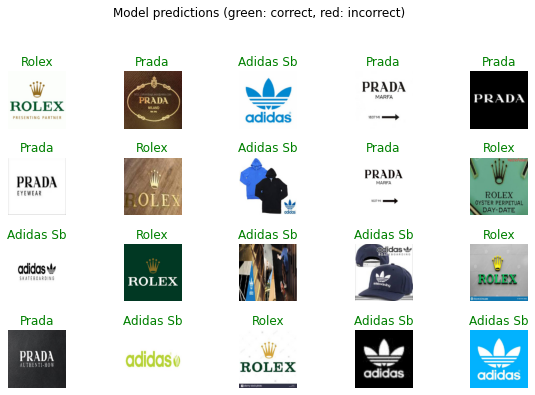

In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
    plt.subplot(6,5,n+1)
    plt.imshow(val_image_batch[n])
    color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
    plt.title(predicted_labels[n].title(), color=color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")